In [1]:
import os
os.chdir("../")
from pos import *
os.chdir("journal")
from plotly import express as px
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import patches
import matplotlib

In [2]:
grupos = {'A':'Immune','B':'Susceptible','C':'Highly Susceptible'}

In [3]:
# vertices con estructura de comunidad
vertices,edges=read("grafo_grado_12.graph")
grado_grupo =np.array([[len(vertice[2:]),grupos[vertice[1]]] for vertice in vertices])            
V=pd.DataFrame(grado_grupo,columns=['Grade','Group']).astype({'Grade': 'int64'})

In [4]:
G=convert_vertices_to_graph(vertices,edges)

In [5]:
porcentaje(vertices)

{'A': 0.369, 'B': 0.325, 'C': 0.306}

In [6]:
from networkx.algorithms import approximation, assortativity,centrality, cluster, distance_measures, link_analysis, smallworld
from networkx.classes import function
from networkx.algorithms.community.quality import modularity
print("Homofilia",homofilia(G))
print("-"*30)
print("Asortatividad",assor(G))
print("-"*30)
print("Porcentaje comunicación")
print(mixing_matrix(G))
print(function.info(G))
print("average clustering coefficient of G: "+str(approximation.average_clustering(G)))
print("Densidad de G: "+str(function.density(G)))
print("degree assortativity:"+str(assortativity.degree_assortativity_coefficient(G)))
print("Coeficiente de agrupamiento de G:"+str(cluster.average_clustering(G)))
print("Diametro de G:"+str(distance_measures.diameter(G)))
#print("Coeficiente de Small World: " + str(smallworld.sigma(G))) #A graph is commonly classified as small-world if sigma>1.
comm=[]
for g in grupos.values():
    comm.append({i for i in V[V.Group == g].index})
print("Modularity of G:"+str(modularity(G,comm)))

Homofilia 0.9878589007383101
------------------------------
Asortatividad 0.9817883296597804
------------------------------
Porcentaje comunicación
[[0.32912223 0.00221493 0.00254307]
 [0.00221493 0.32912223 0.00131255]
 [0.00254307 0.00131255 0.32961444]]
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 6095
Average degree:  12.1900
average clustering coefficient of G: 0.041
Densidad de G: 0.012202202202202202
degree assortativity:-0.02859438301744633
Coeficiente de agrupamiento de G:0.04330256840690038
Diametro de G:8
Modularity of G:0.654524782278888


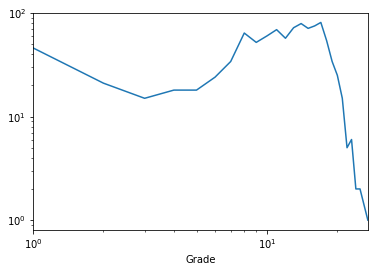

In [7]:
V.groupby('Grade').count().Group.plot(logx=True,logy=True)

In [8]:
# parametros modelo
modelo='g_m_v'
T=300
psi=0.98
nu=0.8
mu=0.14
lamda={'A':0,'B':0.005,'C':0.05}

In [9]:
# inicializacion uniforme aleatoria del miedo al crimen
s0=np.random.rand(len(vertices))

/home/cpulido/anaconda3/envs/pos/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



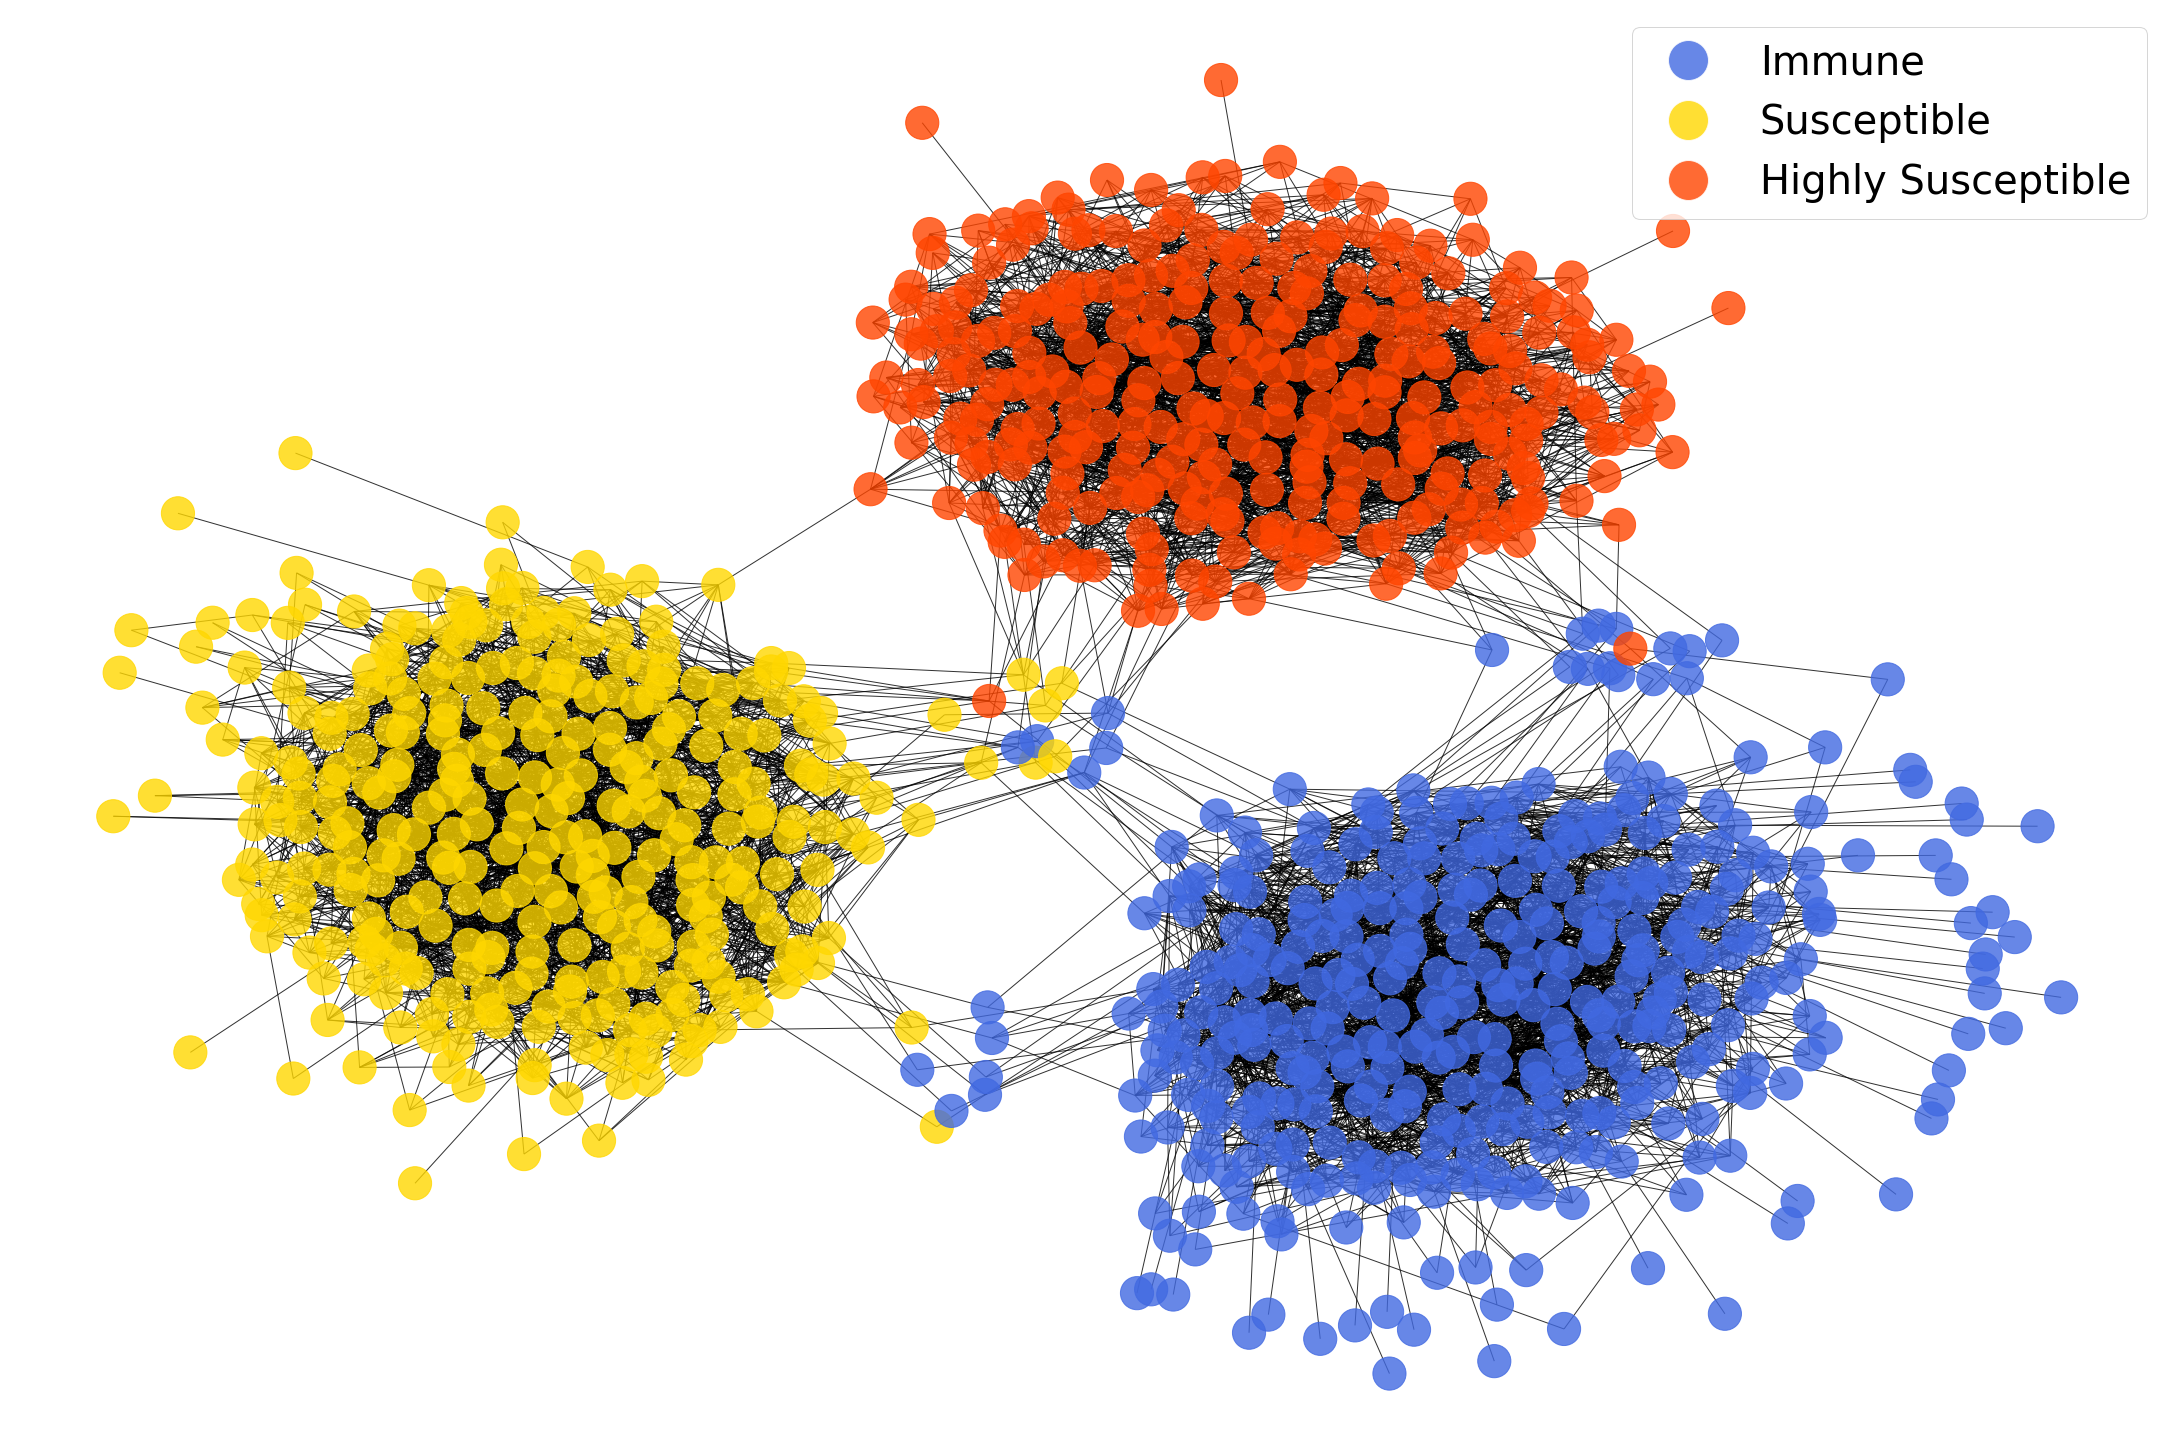

In [10]:
draw_graph(G,np.ones(len(vertices)),legends=grupos,save=True,file="graficas/graph_12.pdf")

In [11]:
# Simulación miedo al crimen
S,conteo=generate(vertices,psi=psi,
           nu=nu,mu=mu,T=T,
           s=s0,lamda=lamda,modelo=modelo,contar=True)
S=S.T
V['conections']=conteo

In [12]:
S[V.Group == grupos['C']][:,100:].mean()

0.8612641614619071

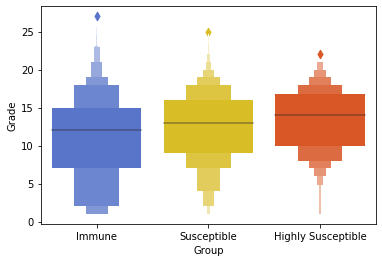

In [13]:
grade_violin=sns.boxenplot(data=V,y='Grade',x='Group',order=list(grupos.values()),palette=["royalblue","gold","orangered"],saturation=0.7)

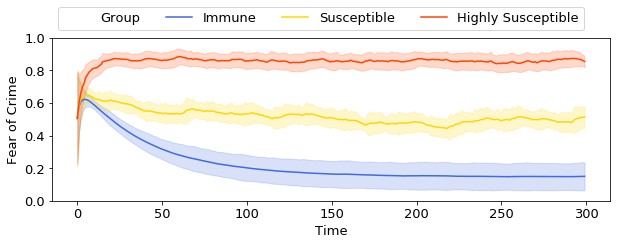

0.4766955508722174

In [14]:
plot(vertices,s0,lamda=lamda,psi=psi,nu=nu,
     mu=mu,modelo=modelo,T=T,draw=True,legends=grupos,save=True,f="graficas/simulacion_multi.pdf")

In [15]:
# indices de cada grupo con maximo grado, minimo grado y uno aleatorio
index_examples=[]
for g in grupos.values():
    index_examples.append([V[V.Group == g].Grade.idxmax(),V[V.Group == g].Grade.idxmin()])
## Convertir a formato que lee plotly
X_multi=pd.DataFrame(index=np.arange(T*6))
X_multi['Fear of Crime']=np.array([list(S[index_examples[i]].flatten()) for i in range(len(index_examples))]).flatten()
X_multi['Time']=list(np.arange(T))*6
X_multi['Group']=np.array([[list(grupos.values())[i]]*2*T for i in range(len(grupos))]).flatten()
X_multi['Grade nodes']=(['max']*T+['min']*T)*3   
X_multi['Model']="Community Structure"
#######################
axis=1
FDP_multi=pd.DataFrame()
FDP_multi['Fear of Crime']=np.concatenate((S[V.Group == grupos['A']].mean(axis=axis),
                S[V.Group == grupos['B']].mean(axis=axis),
                S[V.Group == grupos['C']].mean(axis=axis)
               ))
FDP_multi['Group']=len(S[V.Group == grupos['A']].mean(axis=axis))*[grupos['A']]+len(S[V.Group == grupos['B']].mean(axis=axis))*[grupos['B']]+len(S[V.Group == grupos['C']].mean(axis=axis))*[grupos['C']]
FDP_multi['Model']="Community Structure"

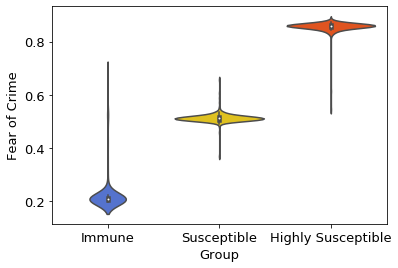

In [16]:
sns.violinplot(data=FDP_multi,y='Fear of Crime',x='Group',palette=["royalblue","gold","orangered"])

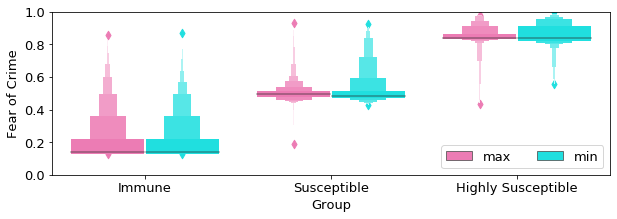

In [17]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,3))
sns.boxenplot(data=X_multi,y='Fear of Crime',x='Group',hue='Grade nodes',ax=ax,palette=['hotpink','cyan'])
plt.legend(loc='lower right',ncol=2)
ax.set_ylim([0, 1])
plt.savefig("graficas/individual_multi.pdf", bbox_inches = "tight")
plt.show()

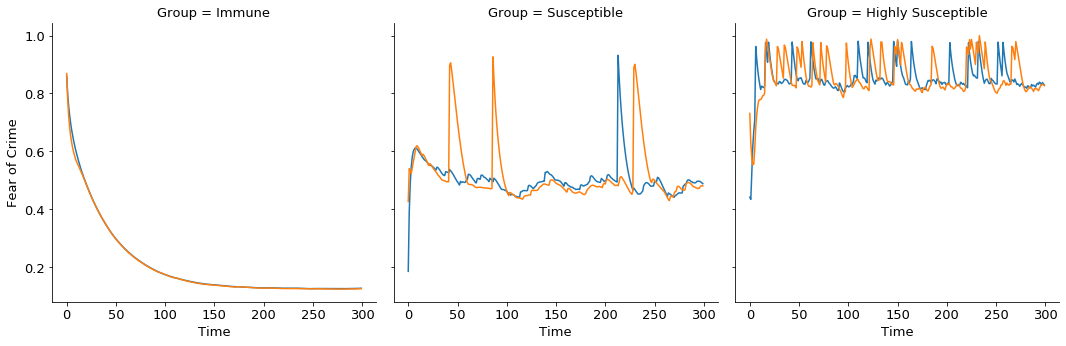

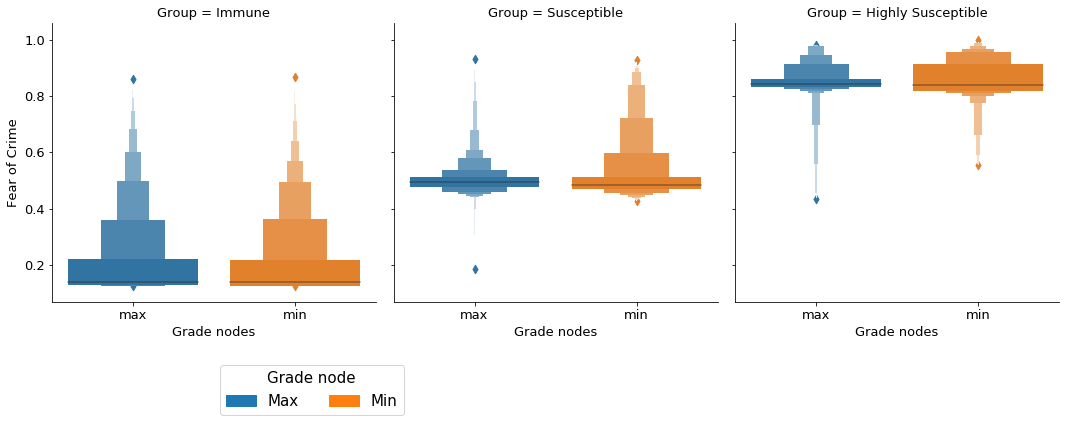

In [18]:
colors=sns.color_palette()[:2]
a=sns.relplot(data=X_multi,x='Time',y='Fear of Crime',hue='Grade nodes',col='Group',kind='line',legend=False,palette=colors)
#plt.savefig("graficas/comportamiento_multi", bbox_inches = "tight")
a=sns.catplot(data=X_multi,y='Fear of Crime',x='Grade nodes',col='Group',kind='boxen',legend_out=True,palette=colors)
handles=[patches.Patch(color=col,label=lab) for col,lab in zip(colors,['Max','Min','Random'])]
plt.legend(handles=handles,title='Grade node',loc='best',ncol=2,
           fontsize='15',
           title_fontsize='15',
           bbox_to_anchor=(-1,-0.2))
#plt.savefig("graficas/comportamiento_multi_box", bbox_inches = "tight")
plt.show()

In [19]:
## modelo sin grafo
modelo='random'

In [20]:
# Simulación miedo al crimen
S,conteo=generate(vertices,psi=psi,
           nu=nu,mu=mu,T=T,
           s=s0,lamda=lamda,modelo=modelo,contar=True)
S=S.T
V['conections']=conteo

In [21]:
S[V.Group == grupos['C']][:,100:].std()

0.13145384605704963

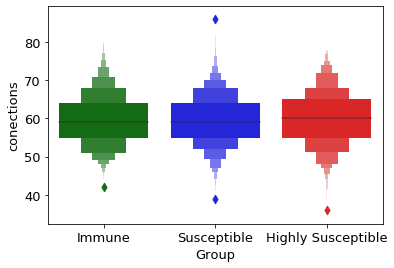

In [22]:
grade_violin=sns.boxenplot(data=V,y='conections',x='Group',order=list(grupos.values()),palette=['g','b','r'],saturation=0.7)

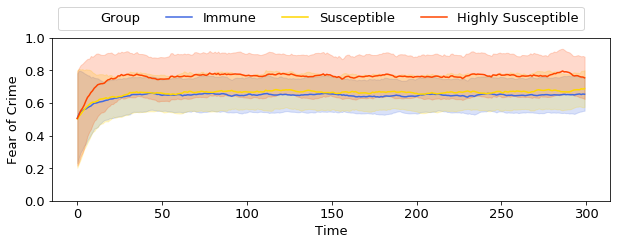

0.6900357077450741

In [23]:
plot(vertices,s0,lamda=lamda,psi=psi,nu=nu,
     mu=mu,modelo=modelo,T=T,draw=True,legends=grupos,save=True,f="graficas/simulacion_random.pdf")

In [24]:
# indices de cada grupo con maximo grado, minimo grado y uno aleatorio
index_examples=[]
for g in grupos.values():
    index_examples.append([V[V.Group == g].conections.idxmax(),V[V.Group == g].conections.idxmin()])
## Convertir a formato que lee plotly
X_random=pd.DataFrame(index=np.arange(T*6))
X_random['Fear of Crime']=np.array([list(S[index_examples[i]].flatten()) for i in range(len(index_examples))]).flatten()
X_random['Time']=list(np.arange(T))*6
X_random['Group']=np.array([[list(grupos.values())[i]]*2*T for i in range(len(grupos))]).flatten()
X_random['Grade nodes']=(['max']*T+['min']*T)*3   
X_random['Model']="Random"
#######################
axis=1
FDP_random=pd.DataFrame()
FDP_random['Fear of Crime']=np.concatenate((S[V.Group == grupos['A']].mean(axis=axis),
                S[V.Group == grupos['B']].mean(axis=axis),
                S[V.Group == grupos['C']].mean(axis=axis)
               ))
FDP_random['Group']=len(S[V.Group == grupos['A']].mean(axis=axis))*[grupos['A']]+len(S[V.Group == grupos['B']].mean(axis=axis))*[grupos['B']]+len(S[V.Group == grupos['C']].mean(axis=axis))*[grupos['C']]
FDP_random['Model']="Random"

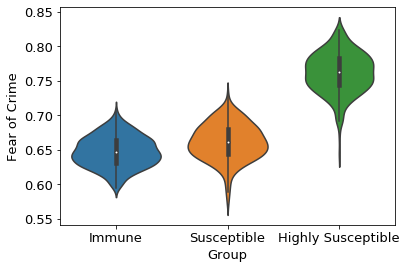

In [25]:
sns.violinplot(data=FDP_random,y='Fear of Crime',x='Group')

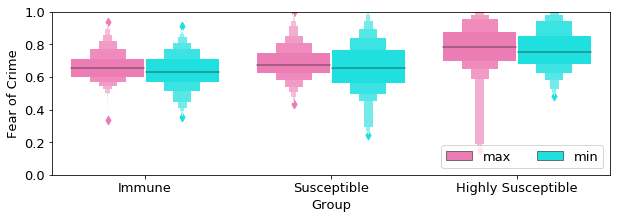

In [26]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,3))
sns.boxenplot(data=X_random,y='Fear of Crime',x='Group',hue='Grade nodes',ax=ax,palette=['hotpink','cyan'])
plt.legend(loc='lower right',ncol=2)
ax.set_ylim([0, 1])
plt.savefig("graficas/individual_random.pdf", bbox_inches = "tight")
plt.show()

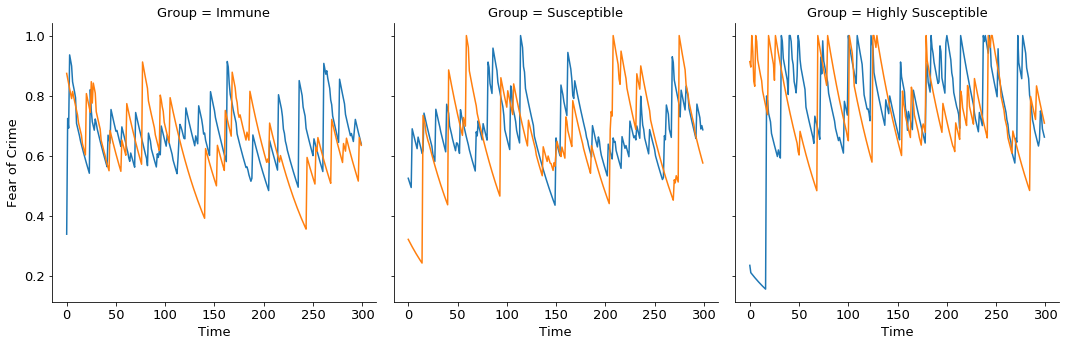

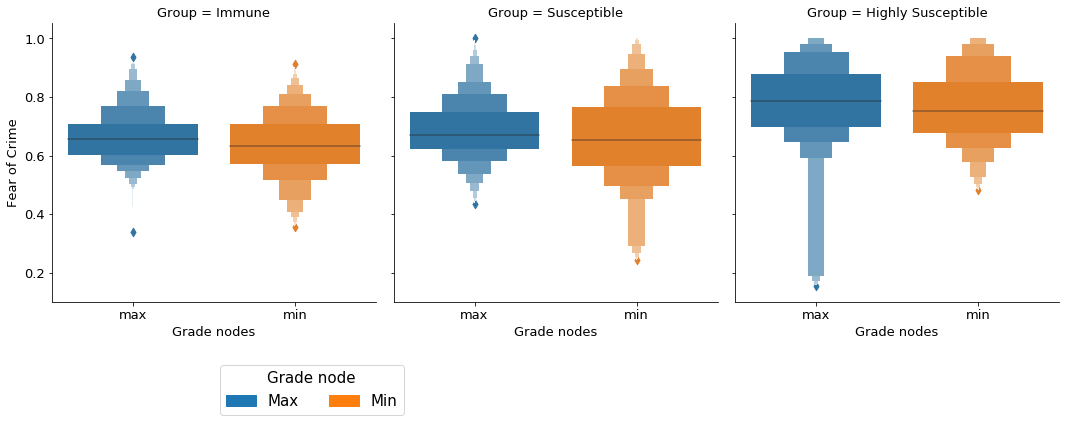

In [27]:
colors=sns.color_palette()[:2]
a=sns.relplot(data=X_random,x='Time',y='Fear of Crime',hue='Grade nodes',col='Group',kind='line',legend=False,palette=colors)
#plt.savefig("graficas/comportamiento_multi", bbox_inches = "tight")
a=sns.catplot(data=X_random,y='Fear of Crime',x='Grade nodes',col='Group',kind='boxen',legend_out=True,palette=colors)
handles=[patches.Patch(color=col,label=lab) for col,lab in zip(colors,['Max','Min','Random'])]
plt.legend(handles=handles,title='Grade node',loc='best',ncol=2,
           fontsize='15',
           title_fontsize='15',
           bbox_to_anchor=(-1,-0.2))
#plt.savefig("graficas/comportamiento_multi_box", bbox_inches = "tight")
plt.show()

In [28]:
X=pd.concat([X_multi,X_random])
FDP=pd.concat([FDP_multi,FDP_random])

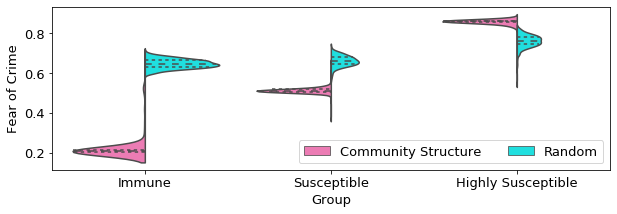

In [29]:
font = {'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,3))
sns.violinplot(data=FDP,y='Fear of Crime',x='Group',hue='Model',ax=ax,palette=['hotpink','cyan'],
               split=True,inner='quartile')
plt.legend(loc='lower right',ncol=2)
plt.savefig("graficas/distribution.pdf", bbox_inches = "tight")
plt.show()


In [30]:
## modelo 1 vecino
modelo='g_1_v'

In [31]:
# Simulación miedo al crimen
S,conteo=generate(vertices,psi=psi,
           nu=nu,mu=mu,T=T,
           s=s0,lamda=lamda,modelo=modelo,contar=True)
S=S.T
V['conections']=conteo

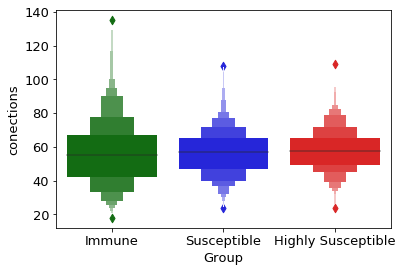

In [32]:
grade_violin=sns.boxenplot(data=V,y='conections',x='Group',order=list(grupos.values()),palette=['g','b','r'],saturation=0.7)

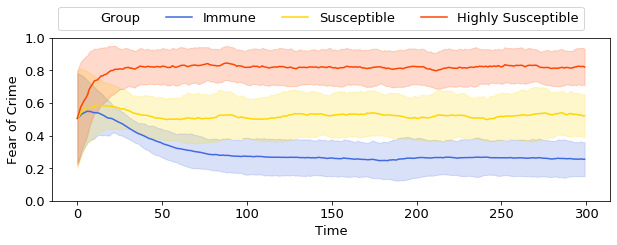

0.5164665223943599

In [33]:
plot(vertices,s0,lamda=lamda,psi=psi,nu=nu,
     mu=mu,modelo=modelo,T=T,draw=True,legends=grupos,save=True,f="graficas/simulacion_one")

In [34]:
# indices de cada grupo con maximo grado, minimo grado y uno aleatorio
index_examples=[]
for g in grupos.values():
    index_examples.append([V[V.Group == g].conections.idxmax(),V[V.Group == g].conections.idxmin(),V[V.Group == g].conections.sample().index[0]])

In [35]:
## Convertir a formato que lee plotly
X=pd.DataFrame(index=np.arange(T*9))
X['Fear']=np.array([list(S[index_examples[i]].flatten()) for i in range(len(index_examples))]).flatten()
X['Time']=list(np.arange(T))*9
X['Group']=np.array([[list(grupos.values())[i]]*3*T for i in range(len(grupos))]).flatten()
X['Grade nodes']=(['max']*T+['min']*T+['random']*T)*3

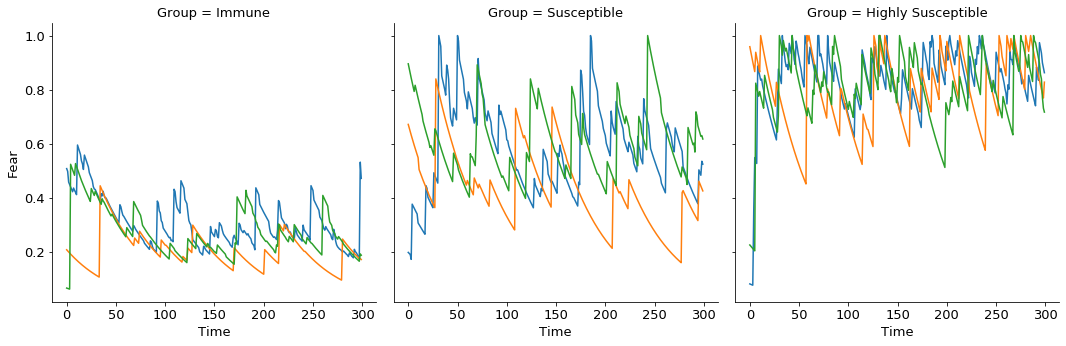

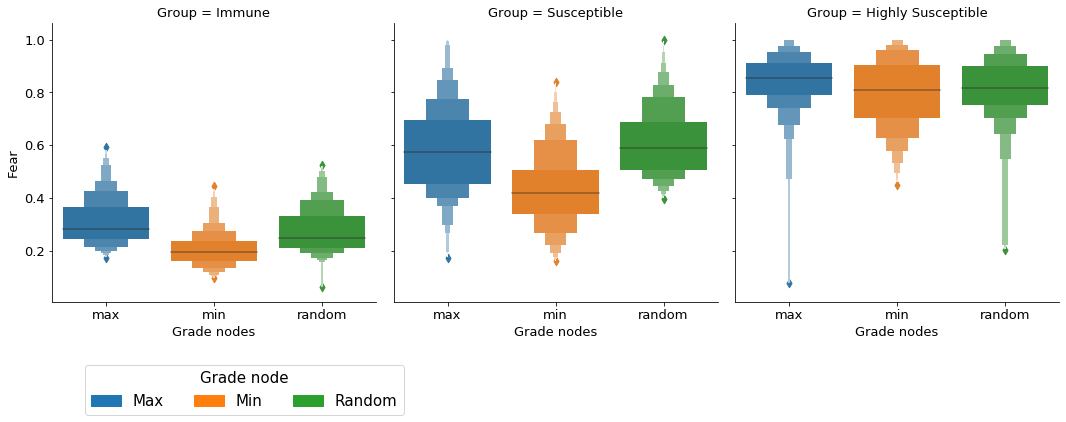

In [36]:
colors=sns.color_palette()[:3]
a=sns.relplot(data=X,x='Time',y='Fear',hue='Grade nodes',col='Group',kind='line',legend=False,palette=colors)
plt.savefig("graficas/comportamiento_one", bbox_inches = "tight")
a=sns.catplot(data=X,y='Fear',x='Grade nodes',col='Group',kind='boxen',legend_out=True,palette=colors)
handles=[patches.Patch(color=col,label=lab) for col,lab in zip(colors,['Max','Min','Random'])]
plt.legend(handles=handles,title='Grade node',loc='best',ncol=3,
           fontsize='15',
           title_fontsize='15',
           bbox_to_anchor=(-1,-0.2))
plt.savefig("graficas/comportamiento_one_box", bbox_inches = "tight")
plt.show()